In [291]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from IPython.display import clear_output
import matplotlib.pyplot as plt
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# normalizando os dados de Close
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, StandardScaler, MinMaxScaler

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

clear_output()

In [100]:
df = pd.read_pickle('data/pkl/df.pkl')
df.head()

,negative_score,neutral_score,positive_score,Close
2020-01-02,0.997598,0.001034,0.001368,3257.850098
2020-01-03,0.000223,0.000103,0.999674,3234.850098
2020-01-06,0.000436,0.000174,0.999390,3246.280029
2020-01-08,0.000252,0.000071,0.999677,3253.050049
2020-01-09,0.000100,0.999775,0.000125,3274.699951


# Treinando a Rede

## sem análise de sentimentos

In [190]:
ts = df[['Close']]

scaler = RobustScaler()
ts.loc[:, 'Close'] = scaler.fit_transform(ts)

train = ts[:int(0.7*(len(ts)))]
test = ts[int(0.7*(len(ts))):]
clear_output()

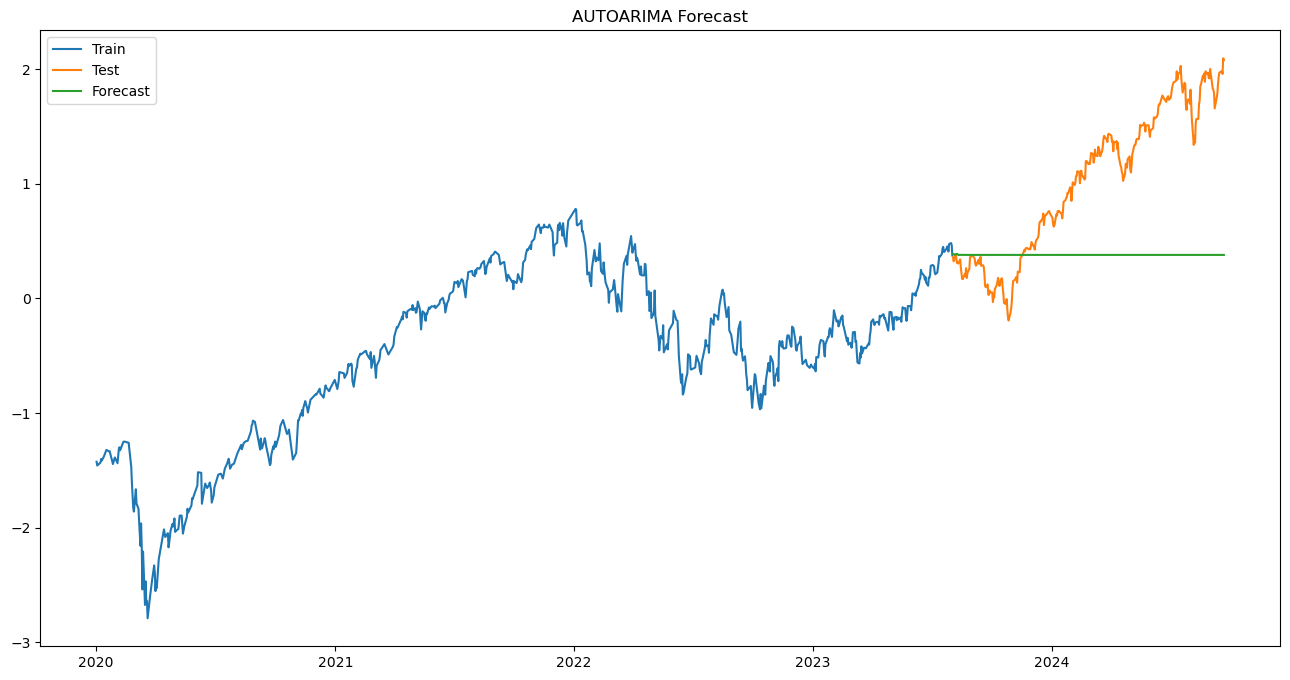

In [191]:
# sem análise de sentimentos, utilizando AUTOARIMA
# fit the model
model = auto_arima(train, error_action='ignore', suppress_warnings=True, seasonal=True, m=7, stepwise=True, trace=True)

model.fit(train)

# predict the future
forecast = model.predict(n_periods=len(test))
clear_output()
# plot forecast
plt.figure(figsize=(16,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.title('AUTOARIMA Forecast')
plt.legend()
plt.show()

In [195]:
# métrica de erro (mae)
forecast_ = pd.DataFrame(forecast.values, index=test.index, columns=['Close'])

test_inv = scaler.inverse_transform(test)
forecast_inv = scaler.inverse_transform(forecast_)

mae = mean_absolute_error(test_inv, forecast_inv)
print(f'MAE: {mae}')

MAE: 516.0476098099953


/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


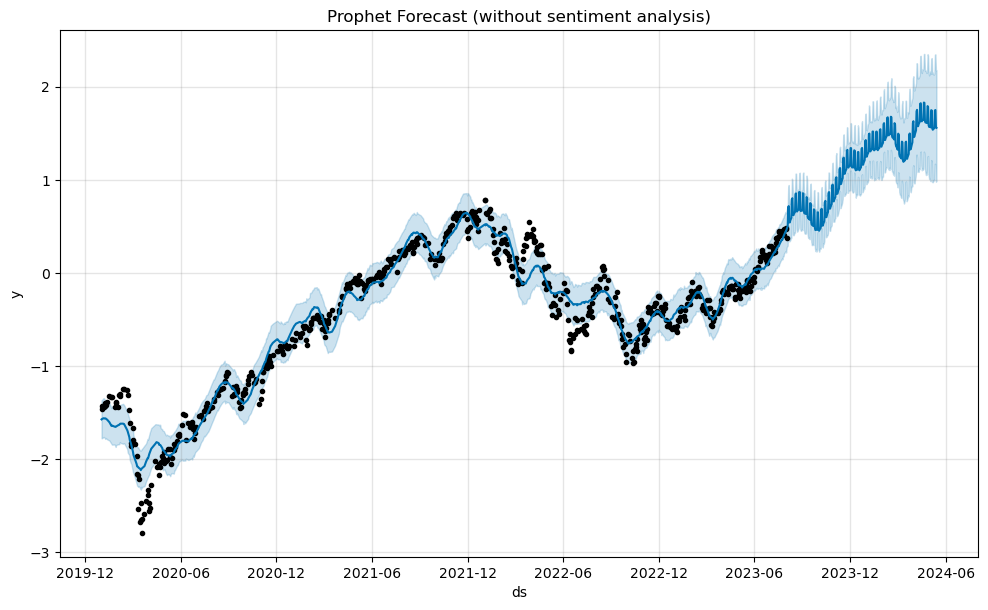

In [197]:
# usando prophet

m = Prophet()
train.loc[:, 'ds'] = train.index
train.loc[:, 'y'] = train['Close']

m.fit(train)

future = m.make_future_dataframe(periods=len(test))

forecast = m.predict(future)
clear_output()
m.plot(forecast)
plt.title('Prophet Forecast (without sentiment analysis)')
plt.show()

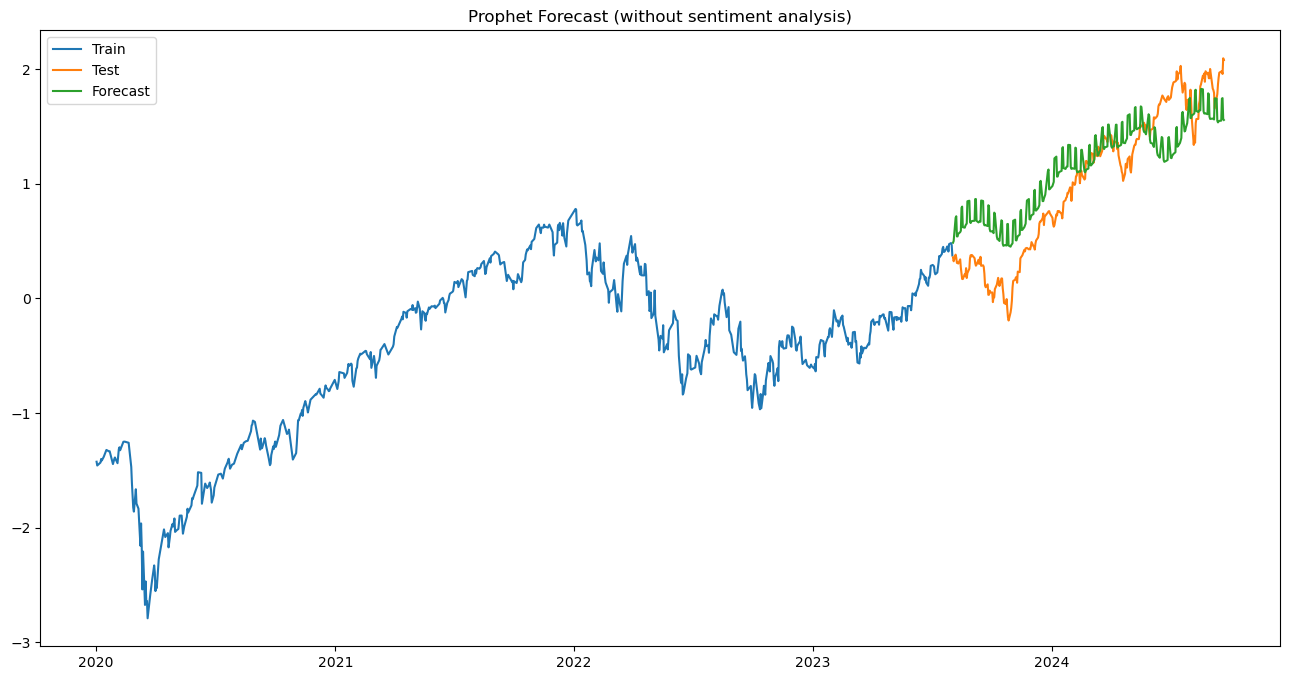

In [198]:
# plot forecast
plt.figure(figsize=(16,8))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')

plt.plot(test.index, forecast['yhat'][len(train):], label='Forecast')
plt.title('Prophet Forecast (without sentiment analysis)')
plt.legend()
plt.show()

/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavi

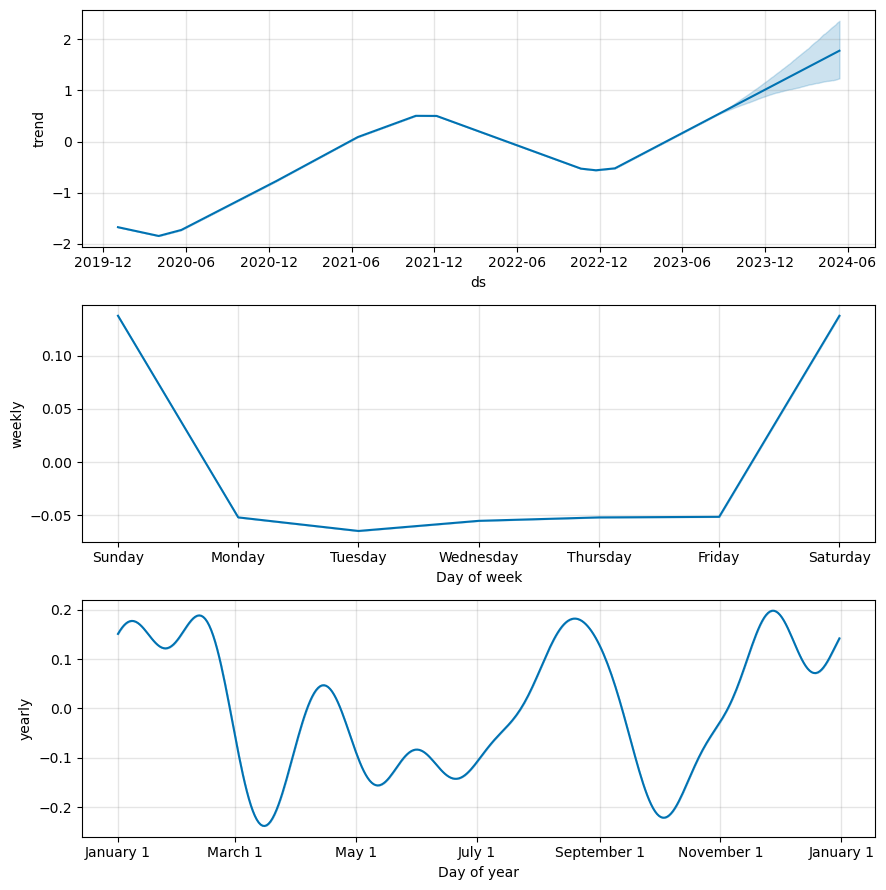

In [199]:
# tendencia
# sazonalidade semanal
# sazonalidade anual

m.plot_components(forecast)
plt.show()

In [201]:
# métricas de erro (MAE)

test_inv = scaler.inverse_transform(test)
forecast_inv = scaler.inverse_transform(forecast[['yhat']][len(train):])

mae = mean_absolute_error(test_inv, forecast_inv)
print(f'MAE: {mae}')

MAE: 207.06958106320974


## Modelo do artigo (LSTM)

In [607]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [608]:
X = df[['negative_score', 'neutral_score', 'positive_score']]
y = df[['Close']]

scaler = MinMaxScaler()
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [609]:
lookback = 14

X_train, y_train = create_dataset(pd.DataFrame(X_train), pd.DataFrame(y_train), lookback)
X_val, y_val = create_dataset(pd.DataFrame(X_val), pd.DataFrame(y_val), lookback)
X_test, y_test = create_dataset(pd.DataFrame(X_test), pd.DataFrame(y_test), lookback)

In [610]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

model.compile(optimizer='adam', loss='mean_squared_error')

/home/erlo/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [611]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, callbacks=[es])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1736 - val_loss: 0.0885
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0923 - val_loss: 0.0828
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0886 - val_loss: 0.0812
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0859 - val_loss: 0.0814
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0846 - val_loss: 0.0810
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0876 - val_loss: 0.0808
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0864 - val_loss: 0.0874
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0966 - val_loss: 0.0834
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0902 - val_loss: 0.0807
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0862 - val_loss: 0.0811
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0841 - val_loss: 0.0815
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

<AxesSubplot: >

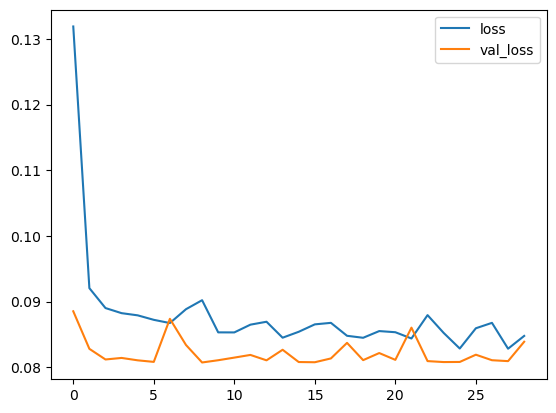

In [612]:
losses = pd.DataFrame(model.history.history)
losses.plot()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
MAE: 24.72577416845365


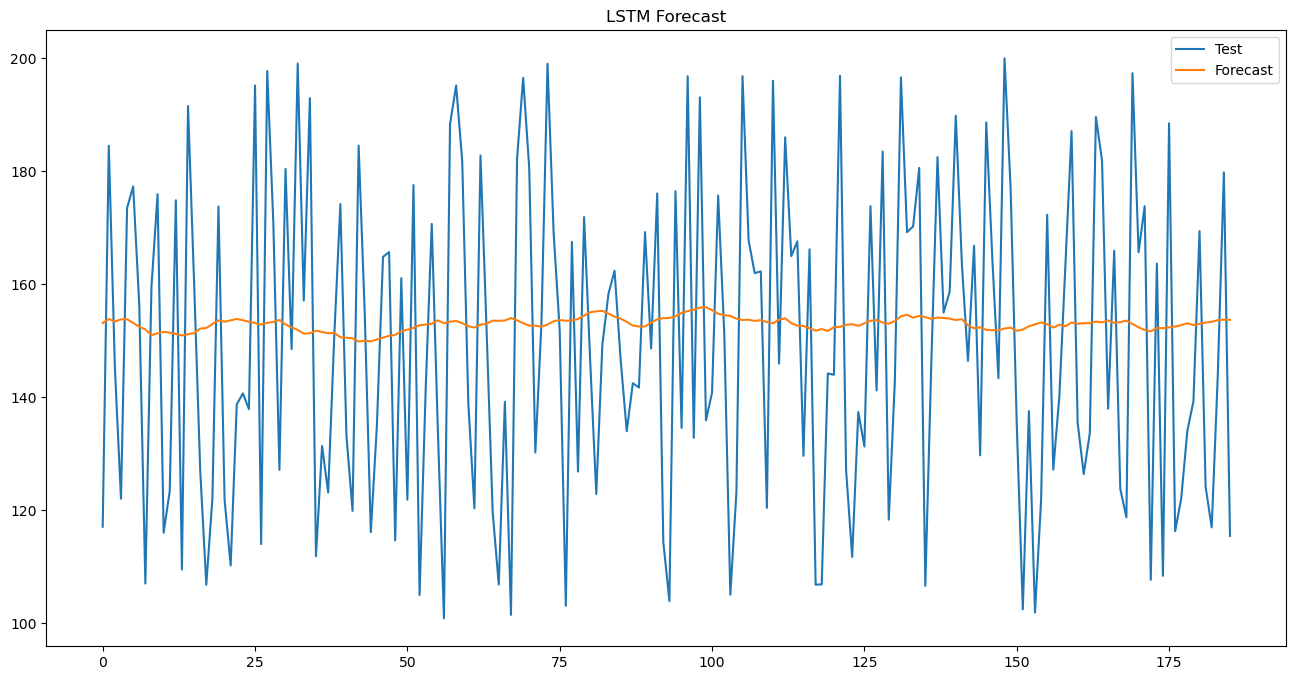

In [613]:
y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'MAE: {mae}')

plt.figure(figsize=(16,8))
plt.plot(y_test_inv, label='Test')
plt.plot(y_pred_inv, label='Forecast')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

## Sequencial e camadas densas

com análise de sentimentos

In [270]:
X = df[['negative_score', 'neutral_score', 'positive_score']]
y = df[['Close']]

scaler = MaxAbsScaler()
y_scaled = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

In [271]:
len(X_train), len(X_val), len(X_test)

(608, 153, 191)

In [272]:
model = Sequential()

model.add(Dense(6, activation='tanh', input_dim=3, kernel_initializer='normal'))
#model.add(Dropout(0.1))
model.add(Dense(3, activation='tanh', kernel_initializer='normal'))
#model.add(Dropout(0.1))

model.add(Dense(1))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

model.compile(optimizer='adam', loss='mae')

print(model.summary())

/home/erlo/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [205]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=16, callbacks=[es])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6947 - val_loss: 0.5629
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4860 - val_loss: 0.2217
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.1512 - val_loss: 0.0944
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0902 - val_loss: 0.0924
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0908 - val_loss: 0.0942
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0904 - val_loss: 0.0924
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0925 - val_loss: 0.0915
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0913 - val_loss: 0.0927
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0914 - val_loss: 0.0918
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0901 - val_loss: 0.0913
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0868 - val_loss: 0.0918
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss:

<AxesSubplot: >

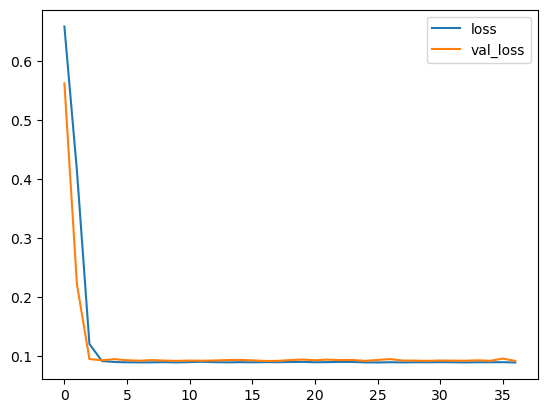

In [206]:
# avaliando o modelo
losses = pd.DataFrame(model.history.history)
losses.plot()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MAE: 433.022926210733


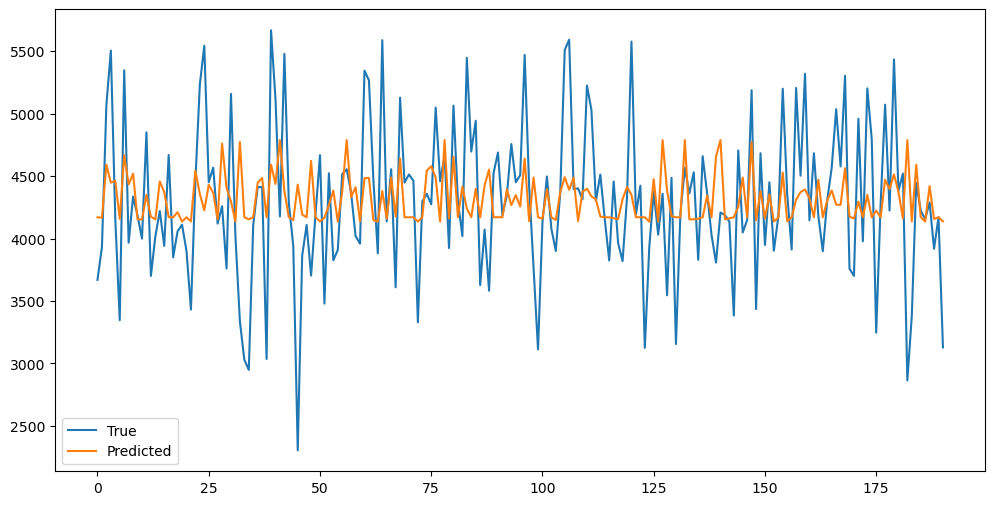

In [207]:
y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f'MAE: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()

## Sequencial + LSTM

In [223]:
model = Sequential()

model.add(LSTM(3, activation='tanh', input_shape = (1, 3), kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))


model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

model.summary()

/home/erlo/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 3)              │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88 (352.00 B)

 Trainable params: 88 (352.00 B)

 Non-trainable params: 0 (0.00 B)

In [224]:
X_train_ = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_ = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_ = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [225]:
history = model.fit(X_train_, y_train, epochs=100, validation_data=(X_val_, y_val), batch_size=16, callbacks=[es])

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7240 - val_loss: 0.6648
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6455 - val_loss: 0.5700
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5473 - val_loss: 0.4518
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4198 - val_loss: 0.3082
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2710 - val_loss: 0.1718
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1639 - val_loss: 0.1198
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1359 - val_loss: 0.1157
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1353 - val_loss: 0.1158
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1367 - val_loss: 0.1117
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1342 - val_loss: 0.1105
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1215 - val_loss: 0.1090
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1

<AxesSubplot: >

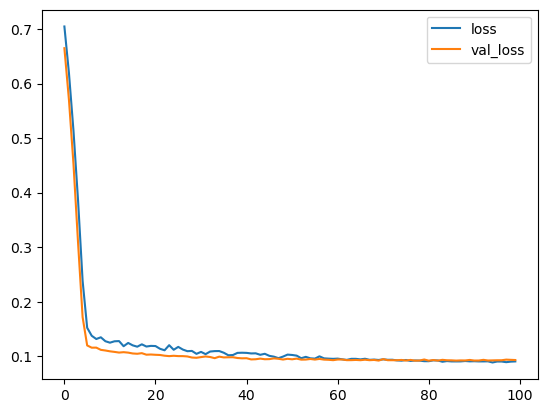

In [226]:
losses = pd.DataFrame(model.history.history)
losses.plot()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 431.8330870623364


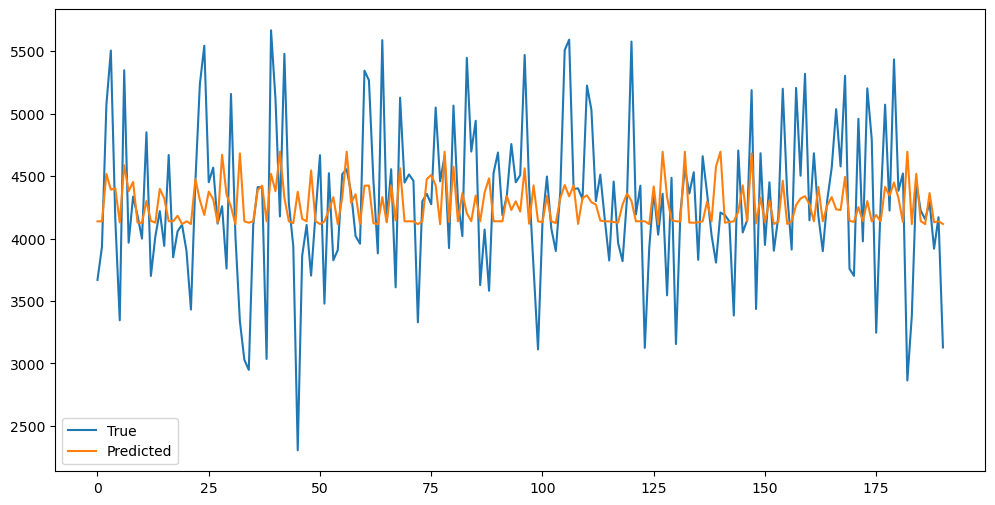

In [227]:
y_pred = model.predict(X_test_)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f'MAE: {mae}')

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()

Prophet com análise de sentimentos

In [228]:
X = df.copy()
X.loc[:, 'ds'] = X.index
X.rename(columns={'Close': 'y'}, inplace=True)
X.dropna(inplace=True, subset=['negative_score'])

X_train = X[:int(0.7*(len(X)))]
X_test = X[int(0.7*(len(X))):]

m = Prophet()
m.add_regressor('negative_score')
m.add_regressor('neutral_score')
m.add_regressor('positive_score')
m.fit(X_train)

20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:58 - cmdstanpy - INFO - Chain [1] done processing


In [229]:
future = m.make_future_dataframe(periods=len(X_test))
future.loc[:, 'negative_score'] = X_train['negative_score']
future.loc[:, 'neutral_score'] = X_train['neutral_score']
future.loc[:, 'positive_score'] = X_train['positive_score']

future.fillna({'negative_score': X_train['negative_score'].mean(), 'neutral_score': X_train['neutral_score'].mean(), 'positive_score': X_train['positive_score'].mean()}, inplace=True)

/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/erlo/.local/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


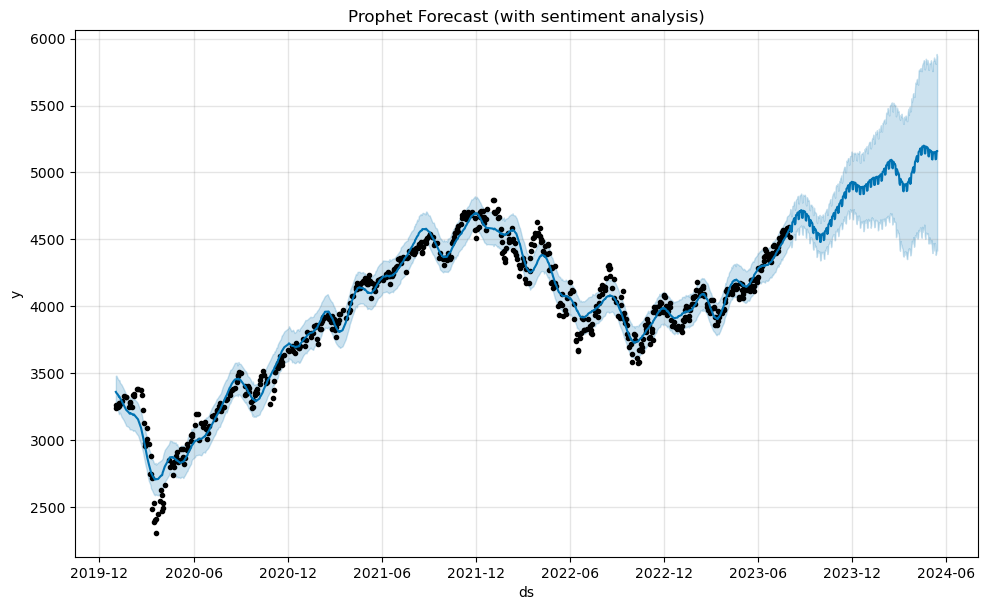

In [230]:
forecast = m.predict(future)

m.plot(forecast)
plt.title('Prophet Forecast (with sentiment analysis)')
plt.show()

MAE: 244.38479407750333


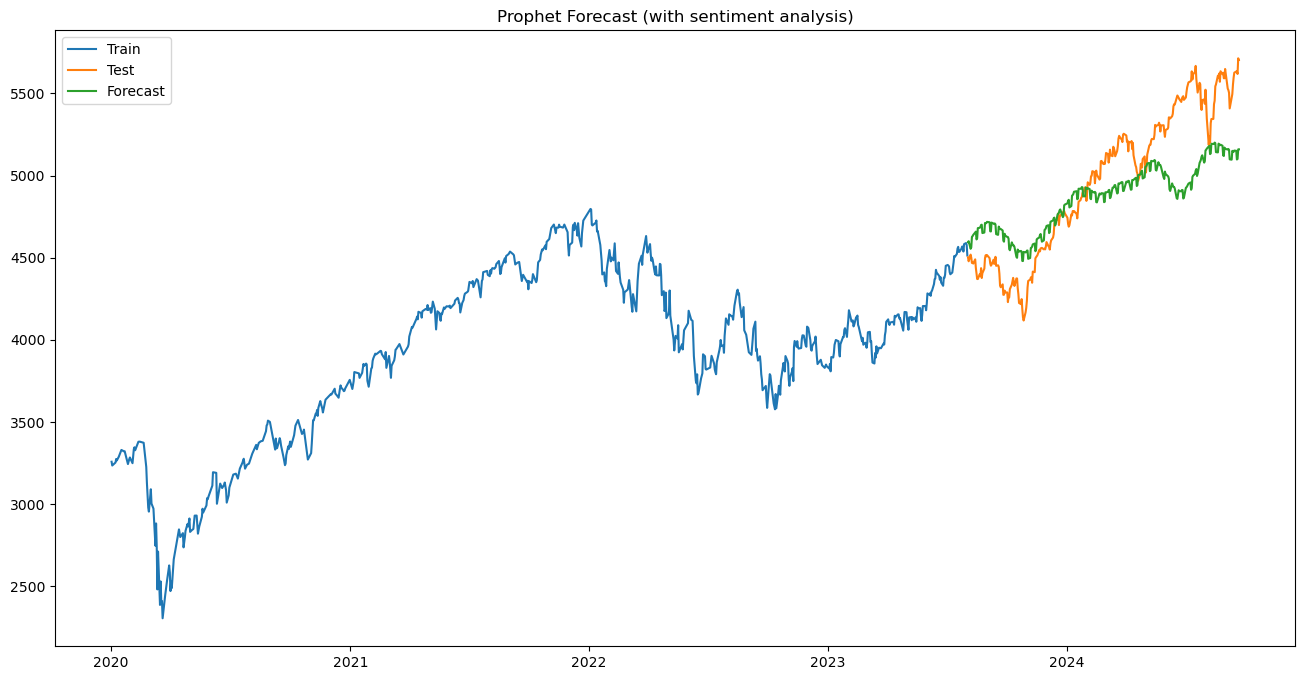

In [231]:
# error metric (MAE)
mae = mean_absolute_error(X_test['y'], forecast['yhat'][len(X_train):])
print(f'MAE: {mae}')

# plot forecast with test data
plt.figure(figsize=(16,8))
plt.plot(X_train['ds'], X_train['y'], label='Train')
plt.plot(X_test['ds'], X_test['y'], label='Test')
plt.plot(X_test['ds'], forecast['yhat'][len(X_train):], label='Forecast')
plt.title('Prophet Forecast (with sentiment analysis)')
plt.legend()
plt.show()